<a href="https://colab.research.google.com/github/HwangSiyeon/ESAA_homework/blob/main/ESAA_HW_0408_TextNormalization_MachineLearningGuide_487_512.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 4. 텍스트 분류 실습 - 20 뉴스그룹 분류
- 텍스트 분류: 특정 문서의 분류를 학습데이터를 통해 학습해 모델 생성 후 이 학습 모델을 이용해 다른 문서의 분류를 예측
- 희소행렬 분류 처리 알고리즘 : 로지스틱 회귀, 선형서포트 벡터머신, 나이브 베이즈
- 예측 성능 비교 시 카운트기반 벡터화, TF-IDF기반 벡터화
- Pipeline객체를 통해 피처 벡터화 파라미터와 GridSearchCV기반 하이퍼 파라미터 튜닝 한꺼번에 수행

---
### 텍스트 정규화
fetch_20newsgroups() : 인터넷에서 로컬 컴퓨터로 데이터 먼저 내려받은 후에 메모리로 데이터 로딩.

In [1]:
from sklearn.datasets import fetch_20newsgroups
news_data = fetch_20newsgroups(subset="all", random_state=156)
print(news_data.keys())
# fetch_20newsgroups()는 사이킷런의 다른 데이터세트 예제와 같이 파이썬 딕셔너리와 유사한 Bunch객체 반환
# 어떠한 key값을 갖고 있는지 반환해본다

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [2]:
# Target 값(클래스)
import pandas as pd

print('target 클래스의 값과 분포도 \n', pd.Series(news_data.target).value_counts().sort_index())
print('target 클래스의 이름들 \n', news_data.target_names)

target 클래스의 값과 분포도 
 0     799
1     973
2     985
3     982
4     963
5     988
6     975
7     990
8     996
9     994
10    999
11    991
12    984
13    990
14    987
15    997
16    910
17    940
18    775
19    628
Name: count, dtype: int64
target 클래스의 이름들 
 ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


- target클래스 값은 0~19로 20개이며 위의 결과처럼 출력된다.
- 이제, 개별 데이터가 텍스트로 어떻게 구성되어 있는지 데이터를 1개만 추출해 값을 확인해보자

In [3]:
print(news_data.data[0])

From: egreen@east.sun.com (Ed Green - Pixel Cruncher)
Subject: Re: Observation re: helmets
Organization: Sun Microsystems, RTP, NC
Lines: 21
Distribution: world
Reply-To: egreen@east.sun.com
NNTP-Posting-Host: laser.east.sun.com

In article 211353@mavenry.altcit.eskimo.com, maven@mavenry.altcit.eskimo.com (Norman Hamer) writes:
> 
> The question for the day is re: passenger helmets, if you don't know for 
>certain who's gonna ride with you (like say you meet them at a .... church 
>meeting, yeah, that's the ticket)... What are some guidelines? Should I just 
>pick up another shoei in my size to have a backup helmet (XL), or should I 
>maybe get an inexpensive one of a smaller size to accomodate my likely 
>passenger? 

If your primary concern is protecting the passenger in the event of a
crash, have him or her fitted for a helmet that is their size.  If your
primary concern is complying with stupid helmet laws, carry a real big
spare (you can put a big or small head in a big helmet, bu

- 헤더와 푸터 정보는 뉴스그룹 분류의 Target클래스 값과 유사한 데이터를 가지고 있는 경우가 많다. 이 장에서는 텍스트 분석을 할 것이므로 헤더와 푸터를 포함시키면 그 의도를 벗어날 수 있다. 따라서 remove 파라미터로 header와 footer를 제거하도록 한다.

In [4]:
from sklearn.datasets import fetch_20newsgroups

#subset = 'train'으로 학습용 데이터만 추출, remove=('headers','footers','quotes')로 내용만 추출
train_news = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'),random_state=156)

X_train = train_news.data
y_train = train_news.target

#subset='test'으로 테스트 데이터만 추출, remove=('headers','footers','quotes')로 내용만 추출
test_news = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'),random_state=156)

X_test = test_news.data
y_test = test_news.target
print('학습 데이터 크기 {0}, 테스트 데이터 크기 {1}'.format(len(train_news.data), len(test_news.data)))

학습 데이터 크기 11314, 테스트 데이터 크기 7532


### 피처 벡터화 변환과 머신러닝 모델 학습/예측/평가
- CountVectorizer로 피처 벡터화 시 주의점 : train데이터로는 .fit(), test데이터는 .transform()을 이용해 변환.(fit_transform아님!)
- 이렇게 해야 학습 시 사용된 피처 개수와 테스트 데이터로 예측할 때 사용할 피처 개수가 달라진다.


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

# Count Vectorization으로 벡터화 변환 수행
cnt_vect = CountVectorizer()
cnt_vect.fit(X_train)

#학습 데이터 피처 벡터화 변환
X_train_cnt_vect = cnt_vect.transform(X_train)

#학습 데이터로 fit()된 CountVectorizer를 이용해 테스트 데이터를 피처 벡터화 변환 수행
X_test_cnt_vect = cnt_vect.transform(X_test)

print('학습 데이터 텍스트의 CountVectorizer Shape:', X_train_cnt_vect.shape)

학습 데이터 텍스트의 CountVectorizer Shape: (11314, 101631)


- 이렇게 피처 벡터화된 데이터에 로지스틱 회귀를 적용해 뉴스그룹에 대한 분류를 예측한다.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# LogisticRegression을 이용해 학습/예측/평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train_cnt_vect, y_train)
pred = lr_clf.predict(X_test_cnt_vect)
print('CountVectorizerd Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test,pred)))

CountVectorizerd Logistic Regression의 예측 정확도는 0.606


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- 지금까지 Count기반 피처 벡터화가 적용된 데이터셋에 대한 로지스틱 회귀를 수행하였다.
- 이번에는 TF-IDF기반 피처 벡터화가 적용된 데이터셋에 대한 예측을 수행한다

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

#TF-IDF 벡터화를 적용해 학습 데이터 세트와 테스트 데이터 세트 변환
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

# LogisticRegression을 이용해 학습/예측/평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train_tfidf_vect, y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Logistic Regression의 예측 정확도 {0:.3}'.format(accuracy_score(y_test, pred)))

TF-IDF Logistic Regression의 예측 정확도 0.674


- TF-IDF기반 > Count기반
- 일반적으로 문서 내에서 텍스트가 많고 많은 문서를 가지는 텍스트 분석에서 카운트 벡터화보다는 TF-IDF벡터화가 좋은 예측결과를 도출한다.
---
- 좀 더 다양한 파라미터의 TF-IDF를 수행해보자.

In [8]:
#stop words 필터링을 추가하고 ngram을 기본 (1,1)에서 (1,2)로 변경
tfidf_vect = TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_df=300)
tfidf_vect.fit(X_train)
X_train_tfidf_vect = tfidf_vect.transform(X_train)
X_test_tfidf_vect = tfidf_vect.transform(X_test)

lr_clf = LogisticRegression()
lr_clf.fit(X_train_tfidf_vect, y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test,pred)))

TF-IDF Vectorized Logistic Regression의 예측 정확도는 0.692


- 이제 GridCV를 통해 로지스틱 회귀위 하이퍼 파라미터 최적화를 수행한다.

In [ ]:
from sklearn.model_selection import GridSearchCV

#최적 C 값 도출 튜닝 수행. CV는 3폴드 세트로 설정
params = {'C':[0.01,0.1,1,5,10]}
grid_cv_lr= GridSearchCV(lr_clf, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv_lr.fit(X_train_tfidf_vect, y_train)
print('Logistric Regression best C parameter :', grid_cv_lr.best_params_)

# 최적 C 값으로 학습된 grid_cv로 예측 및 정확도 평가
pred = grid_cv_lr.predict(X_test_tfidf_vect)
print('TR-IDF Vectorized Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


- C=10일 때 GridSearchCV가 교차 검즈 테스트 세트에서 가장 좋은 예측 성능을 나타냈다.

### 사이킷런 파이프라인 사용 및 GridSearchCV와의 결합
- 머신러닝에서 Pipeline: 데이터의 가공, 변환 등의 전처리와 알고리즘 적용을 마치 '수도관(pipe)에서 물이 흐르듯' 한꺼번에 스트림 기반으로 처리한다는 의미. 더 직관적인 ML모델 코드를 생성 가능. 전처리와 머신러닝 학습 과정을 통일된 API기반에서 처리가능(-> 더 직관적인 ML모델코드).
또한 대용량 데이터의 피처 벡터화 결과를 별도 데이터로 저장하지 않고 스트림 기반에서 바로 머신러닝 알고리즘의 데이터로 입력할 수 있기 때문에 수행 시간을 절약할 수 있다.

In [ ]:
from sklearn.pipeline import Pipeline

#위에서 텍스트 분류 예제 코드를 Pipeline을 이용해 작성
pipeline = Pipeline([('tfidf_vect',TfidfVectorizer(stop_words='english')),
                     ('lr_clf',LogisticRegression(random_state=156))])

- 두 모델 객체를 파이프라인으로 연결
- TfldVectorizer의 학습데이터와 테스트 데이터에 대한 fit()과 transform()수행을 통한 피처 벡터화와 LogisticRegressor의 fit()rhk predict()를 통일하여 수행

In [ ]:
from sklearn.pipeline import Pipeline

# TfidfVectorizer 객체를 tfidf_vect로, LogisticRegression 객체를 lr_clf로 생성하는 Pipeline 생성
pipeline = Pipeline([
    ('tfidf_vect',TfidfVectorizer(stop_words='english',ngram_range=(1,2),max_df=300)),
    ('lr_clf',LogisticRegression(C=10))
])

# 별도의 TfidfVectorizer 객체의 fit(), transform() 과 LogisticRegression의 fit(), predict()가 필요없음
# pipeline의 fit()과 predict()만으로 한꺼번에 피처 벡터화와 ML 학습/예측이 가능
pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)
print('Pipeline을 통한 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test,pred)))

- Pipeline + GridSearchCV

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf_vect',TfidfVectorizer(stop_words='english')),
    ('lr_clf',LogisticRegression())
])

#Pipeline에 기술된 각각의 객체 변수에 언더바(_) 2개를 연달아 붙여 GridSearchCV
#파라미터/하이퍼 파라미터 이름과 값을 설정
params = {'tfidf_vect__ngram_range': [(1,1),(1,2),(1,3)],
          'tfidf_vect__max_df':[100,300,700],
          'lr_clf__C':[1,5,10]}

# GridSearchCV의 생성자에 Estimator가 아닌 Pipeline 객체 입력
grid_cv_pipe = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy',verbose=1)
grid_cv_pipe.fit(X_train, y_train)
print(grid_cv_pipe.best_params_, grid_cv_pipe.best_score_)

pred = grid_cv_pipe.predict(X_test)
print('Pipeline을 통한 Logistic Regression의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test, pred)))

## 감성분석
- 감성분석 : 텍스트가 나타내는 여러 주관적인 단어와 문맥을 기반으로 감성수치를 계산. 긍정감성지수와 부정감성지수로 구성되며 이들 지수를 합산해 계산한다.
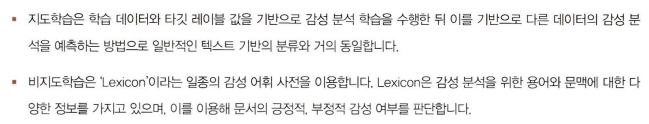

### 지도학습 기반 감성 분석 실습 - IMDB 영화평

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
review_df = pd.read_csv('', header=0, sep="\t", quoting=3)

In [ ]:
print(review_df['review'][0])

In [ ]:
import re

#  <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('', ' ')

# 파이썬의 정규 표현식 모듈인 re를 이용해 영어 문자열이 아닌 문자는 모두 공백으로 변환
review_df['review'] = review_df['review'].apply( lambda x: re.sub("[^a-xA-Z]", " ", x))

In [ ]:
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(['id','sentiment'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(feature_df, class_df, test_size=0.3, random_state=156)

X_train.shape, X_test.shape

# 이미지 데이터 돌릴일이 있었는데 램이 부족해서 미완입니다ㅠㅠㅠㅠㅠㅠ